# Fura Renewals Prediction - Optimized Notebook

## 1. Introduction & Objectives
Objective:
Predict energy renewals based on time series data including balancing, demand, generation, and price.

## 2. Setup and Imports
Uncomment the line below if running in a new environment

In [1]:
# !pip install xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings

from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

import math

from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import itertools


warnings.filterwarnings("ignore")
plt.style.use('ggplot')

## 3. Data Ingestion & Pre-processing

In [2]:
balancing = pd.read_csv('data/balancing_data.csv')
demand_load = pd.read_csv('data/demand_load_data.csv')
generation = pd.read_csv('data/generation_data.csv')
price = pd.read_csv('data/price_data.csv')

Converting the date column to the correct datatype and merging the datasets

In [3]:
def preprocess(df, time_col='GMT Time'):
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(by=time_col)
    return df

balancing = preprocess(balancing)
demand_load = preprocess(demand_load)
generation = preprocess(generation)
price = preprocess(price)

from functools import reduce
merged_df = reduce(lambda left, right: pd.merge(left, right, on='GMT Time', how='inner'),
                   [balancing, demand_load, generation, price])

In [4]:
merged_df.head(3)

GMT Time Price (£/MWh)  net_imbalnace_volume (MW)  \
0 2018-01-01 00:00:00         55.94                     -77.05   
1 2018-01-01 00:30:00         55.94                    -334.76   
2 2018-01-01 01:00:00         62.94                    -219.78   

  BM Bid Acceptances (MW) BM Offer Acceptances (total) - GB (MW)  \
0                -1833.86                                1910.98   
1                -1443.78                                1778.09   
2                -1580.12                                 1799.9   

  Total BSAD Volume - Turn Up - GB (MW)  \
0                                  1104   
1                                  1104   
2                                  1104   

  Total BSAD Volume - Turn Down - GB (MW) Total BSAD Volume - Total - GB (MW)  \
0                                    -900                                 204   
1                                    -900                                 204   
2                                    -900                                 204   

  Intraday Volume (EPEX Outturn, APX, MID) - GB (MWh)  \
0                                             781.35    
1                                              655.4    
2                                              821.5    

  Loss of Load Probability - Latest - GB ()  ...  \
0                                         0  ...   
1                                         0  ...   
2                                         0  ...   

  Actual Aggregated Generation By Type - Fossil Hard Coal - GB (MW)  \
0                                               1143                  
1                                               1308                  
2                                               1461                  

  Actual Aggregated Generation By Type - Fossil Oil - GB (MW)  \
0                                                  0            
1                                                  0            
2                                                  0            

  Actual Aggregated Generation By Type - Hydro Pumped Storage - GB (MW)  \
0                                                  0                      
1                                                  0                      
2                                                206                      

  Actual Aggregated Generation By Type - Hydro Run-of-River and Poundage - GB (MW)  \
0                                                352                                 
1                                                351                                 
2                                                355                                 

  Actual Aggregated Generation By Type - Nuclear - GB (MW)  \
0                                               7263         
1                                               7268         
2                                               7260         

  Actual Aggregated Generation By Type - Solar - GB (MW)  \
0                                                  0       
1                                                  0       
2                                                  0       

  Actual Aggregated Generation By Type - Wind Onshore - GB (MW)  \
0                                             4950.3              
1                                            5004.55              
2                                            4878.41              

  Actual Aggregated Generation By Type - Wind Offshore - GB (MW)  \
0                                            3777.01               
1                                            3824.89               
2                                            3831.16               

  Day Ahead Price (EPEX half-hourly, local) - GB (LC/MWh)  \
0                                              46.73        
1                                              50.11        
2                                               56.6        

  Intraday Price (EPEX Outturn, APX, MID) - GB (£/MWh)  
0            

## 4. Exploratory Data Analysis

In [5]:
print(merged_df.info())
print(merged_df.describe())
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118320 entries, 0 to 118319
Data columns (total 24 columns):
 #   Column                                                                            Non-Null Count   Dtype         
---  ------                                                                            --------------   -----         
 0   GMT Time                                                                          118320 non-null  datetime64[ns]
 1   Price (£/MWh)                                                                     118320 non-null  object        
 2   net_imbalnace_volume (MW)                                                         118320 non-null  float64       
 3   BM Bid Acceptances (MW)                                                           118320 non-null  object        
 4   BM Offer Acceptances (total) - GB (MW)                                            118320 non-null  object        
 5   Total BSAD Volume - Turn Up - GB (MW)              

In [6]:
# Set date column as index
merged_df.set_index('GMT Time', inplace=True)

# Create list of columns
col_list = list(merged_df.columns)

# Convert data type of the dataset to numeric values
merged_df[col_list] = merged_df[col_list].apply(pd.to_numeric, errors='coerce')

print(merged_df.info())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118320 entries, 2018-01-01 00:00:00 to 2024-09-30 23:30:00
Data columns (total 23 columns):
 #   Column                                                                            Non-Null Count   Dtype  
---  ------                                                                            --------------   -----  
 0   Price (£/MWh)                                                                     118275 non-null  float64
 1   net_imbalnace_volume (MW)                                                         118320 non-null  float64
 2   BM Bid Acceptances (MW)                                                           117768 non-null  float64
 3   BM Offer Acceptances (total) - GB (MW)                                            116849 non-null  float64
 4   Total BSAD Volume - Turn Up - GB (MW)                                             62465 non-null   float64
 5   Total BSAD Volume - Turn Down - GB (MW)                           

### 4.1. Visualize the data and look for correlations

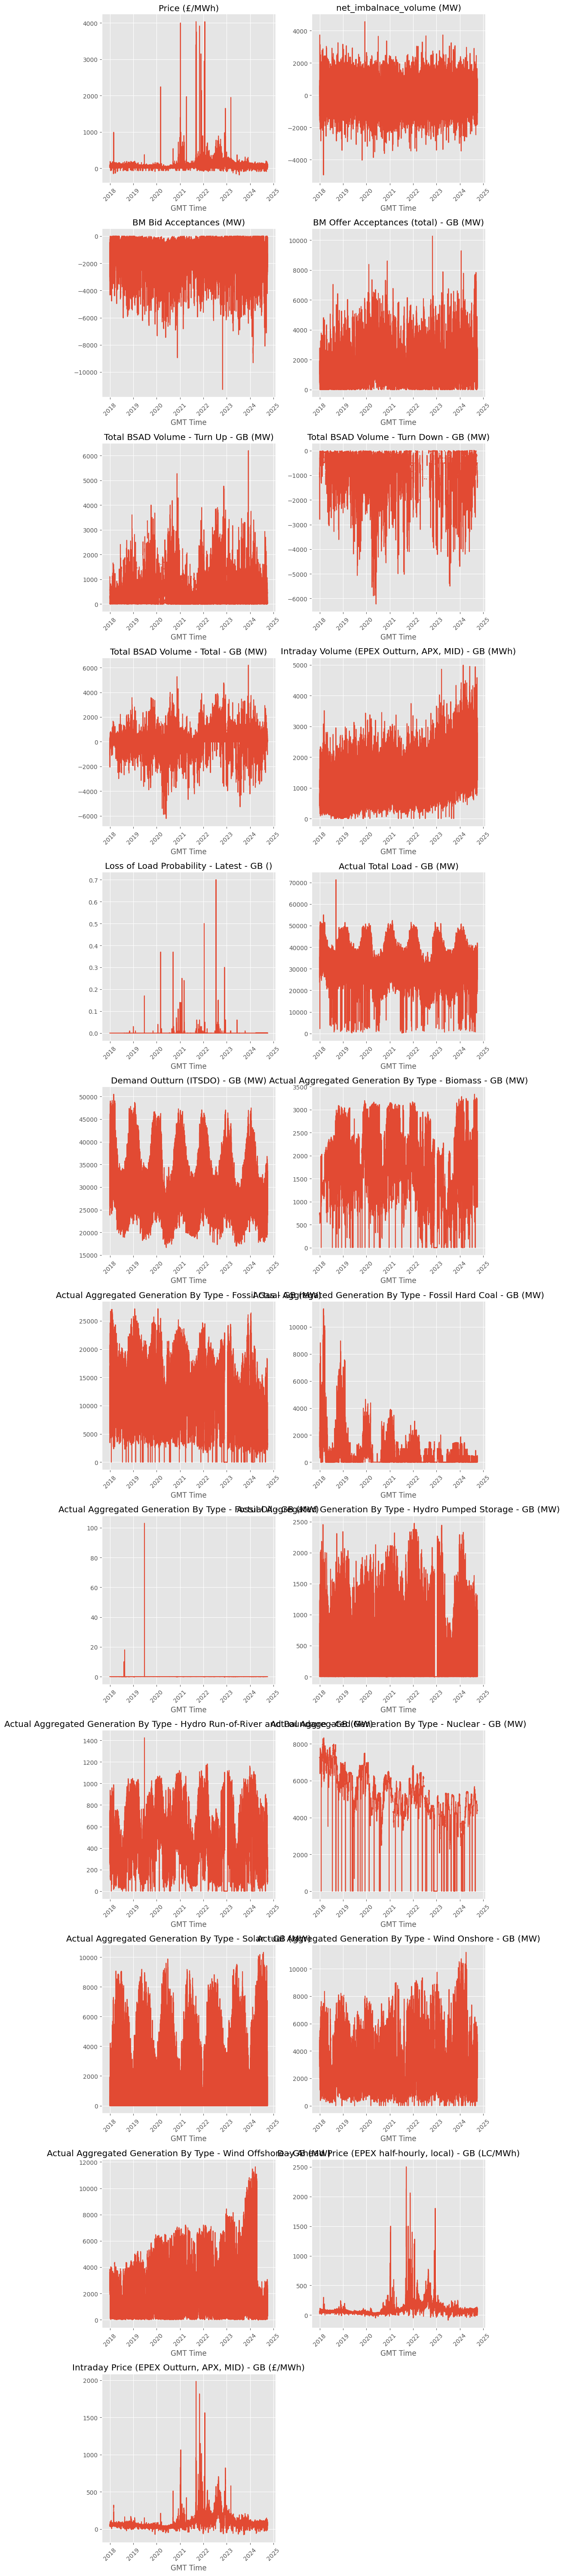

In [7]:
# Define plot grid structure

# Define the number of columns per row & calculate the number of rows required

plots_per_row = 2
n_cols = len(merged_df.columns)
n_rows = math.ceil(n_cols / plots_per_row)

# Create subplots with 2 charts per row layout
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(5 * plots_per_row, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, column in enumerate(merged_df.columns):
    axes[i].plot(merged_df.index, merged_df[column], label=column)
    axes[i].set_xlabel('GMT Time')
    axes[i].set_title(f'{column}')
    axes[i].tick_params(axis='x', rotation=45)

# Turn off unused subplots
for j in range(len(merged_df.columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

#### **Observations:**

* Net Imbalance Volume(NIV) has a somewhat relevant correlation with Bid and Offer Acceptances. This can be used as part of the features for NIV prediction
* Besides Intraday and Day ahead Price, it is not clear how other attributes would impact System Price prediction.

Below, I use a correlation heatmap to check correlations


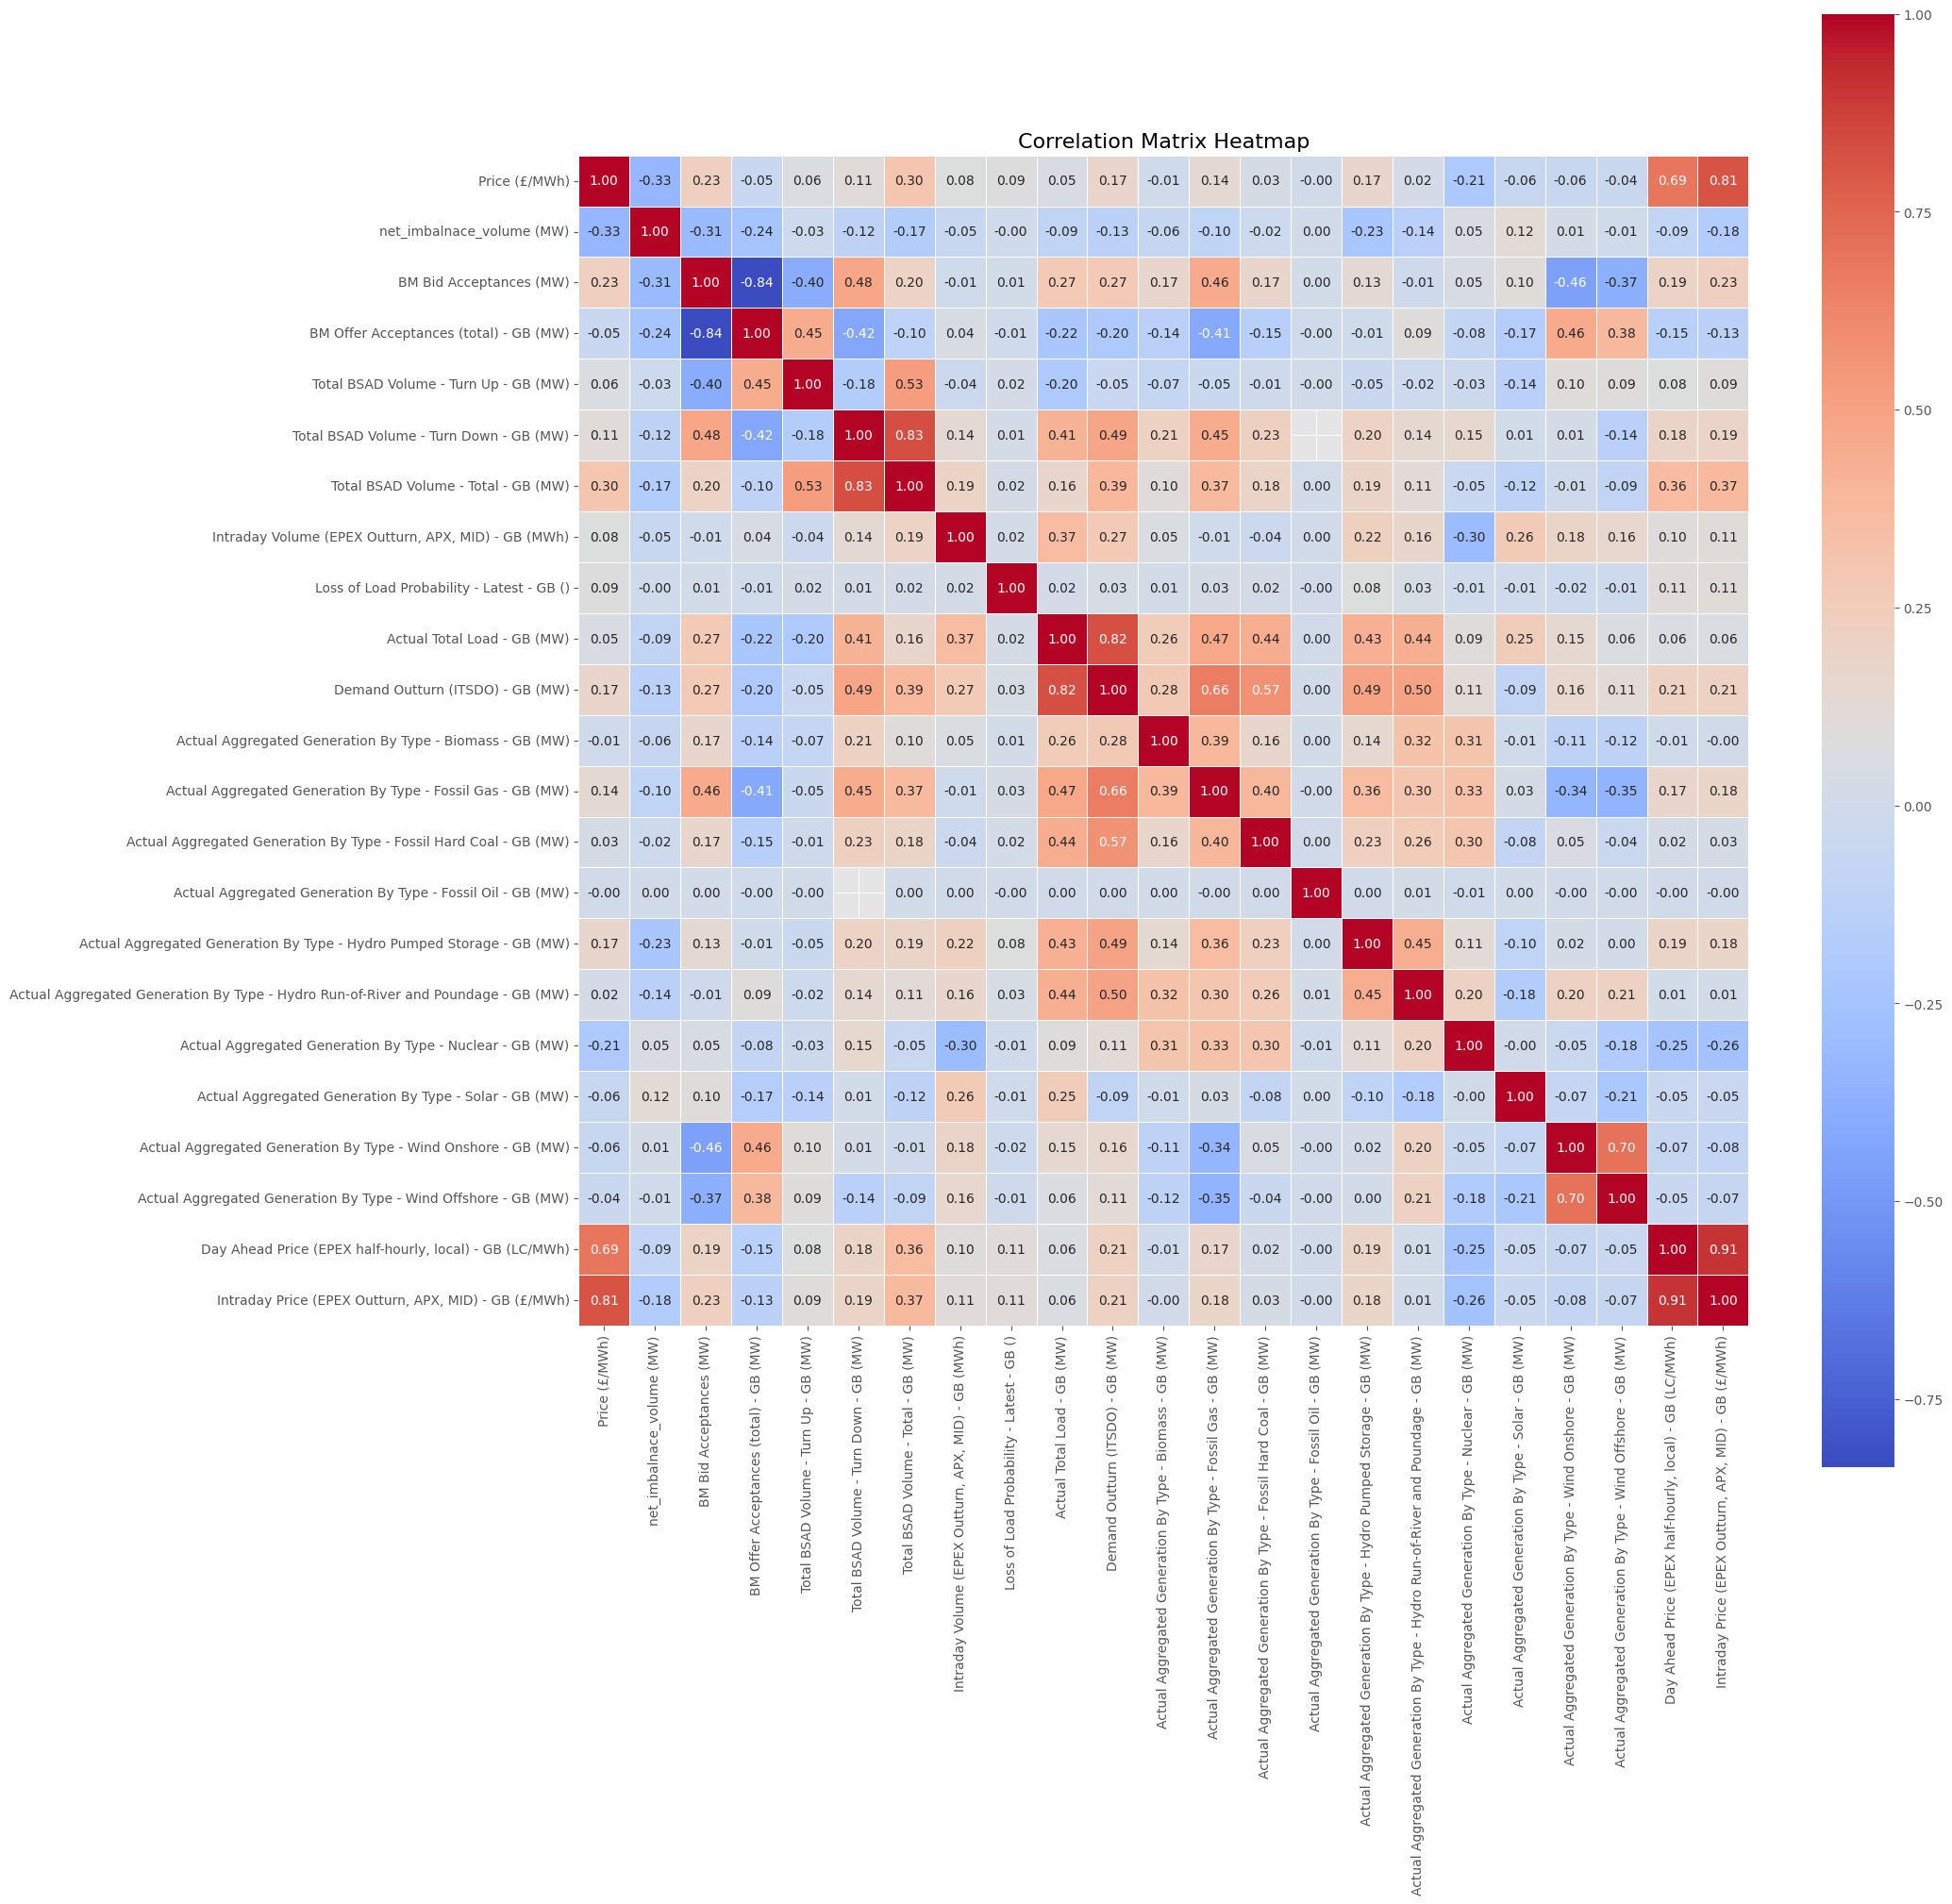

In [8]:
# Create the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(
    merged_df.corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar=True,
    square=True,
    linewidths=0.5
)

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

### 4.2. Price by time of day and season

In [9]:
# Create a new dataframe with price data and additional features
time_features_df = merged_df[['Price (£/MWh)']].copy()
time_features_df['Hour'] = time_features_df.index.hour
time_features_df['Month'] = time_features_df.index.month

# Define seasons based on months
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

time_features_df['Season'] = time_features_df['Month'].apply(get_season)

# Group by hour and season, and calculate the mean price
price_by_time_season = time_features_df.groupby(['Hour', 'Season'])['Price (£/MWh)'].mean().reset_index()

# Create a Plotly line plot
fig = px.line(
    price_by_time_season,
    x='Hour',
    y='Price (£/MWh)',
    color='Season',
    markers=True,
    title='Price by Time of Day and Season',
    labels={'Hour': 'Hour of Day', 'Price (£/MWh)': 'Price (£/MWh)'},
)

# Update layout for better appearance
fig.update_layout(
    legend_title_text='Season',
    yaxis=dict(title='Price (£/MWh)')
)

fig.show()

# 5. Time series analysis of Price

I want to focus on Price data from 2024 onwards

In [10]:
df = merged_df.loc[(merged_df.index >= '2024-01-01')][['Price (£/MWh)']].copy()
print(df.info())
print(df.describe())
print(df.head())
print("\nMissing values in the dataset:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13152 entries, 2024-01-01 00:00:00 to 2024-09-30 23:30:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price (£/MWh)  13152 non-null  float64
dtypes: float64(1)
memory usage: 205.5 KB
None
       Price (£/MWh)
count   13152.000000
mean       65.801735
std        37.861504
min       -91.820000
25%        47.650000
50%        67.000000
75%        95.000000
max       200.000000
                     Price (£/MWh)
GMT Time                          
2024-01-01 00:00:00          90.00
2024-01-01 00:30:00         100.00
2024-01-01 01:00:00          57.43
2024-01-01 01:30:00         129.84
2024-01-01 02:00:00         110.00

Missing values in the dataset:
Price (£/MWh)    0
dtype: int64


Here, I take a look at the trend, seasonality and residuals of the price data

In [11]:
# Perform additive decomposition
decomposition = seasonal_decompose(df['Price (£/MWh)'], model="additive", period=48)

# Create a 4x1 subplot
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True,
    subplot_titles=("Original Time Series", "Trend Component", "Seasonal Component", "Residual Component")
)

# Add each component to its subplot
fig.add_trace(go.Scatter(x=df.index, y=df['Price (£/MWh)'], mode='lines', name='Original', line=dict(color='black')), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=decomposition.trend, mode='lines', name='Trend', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=decomposition.seasonal, mode='lines', name='Seasonal', line=dict(color='green')), row=3, col=1)
fig.add_trace(go.Scatter(x=df.index, y=decomposition.resid, mode='lines', name='Residual', line=dict(color='red')), row=4, col=1)

# Update layout
fig.update_layout(
    height=1000,
    title_text="Additive Decomposition of 'Price (£/MWh)'",
    showlegend=False,
    template="plotly_white"
)

fig.update_xaxes(title_text="Time", row=4, col=1)
fig.update_yaxes(title_text="Price (£/MWh)", row=1, col=1)

fig.show()


Checking for stationarity

In [12]:
#check if original data and residuals are stationary

add_adf_result = adfuller(decomposition.resid.dropna())

if add_adf_result[1] > 0.05:
  print(f'Additive residuals p-value is {round(add_adf_result[1], 4)}, residuals are non-stationary')
else:
  print(f'Additive residuals p-value is {round(add_adf_result[1], 4)}, residuals are stationary')

adf_result = adfuller(df['Price (£/MWh)'])

#Print out based on if p-value > 0.05: data is non-stationary

if adf_result[1] > 0.05:
  print(f'Price p-value is {round(adf_result[1], 4)}, Price data is non-stationary. Differencing needed.')
else:
  print(f'Price p-value is {round(adf_result[1], 4)}, Price data is stationary')


Additive residuals p-value is 0.0, residuals are stationary
Price p-value is 0.0, Price data is stationary


Checking for Price autocorrelation

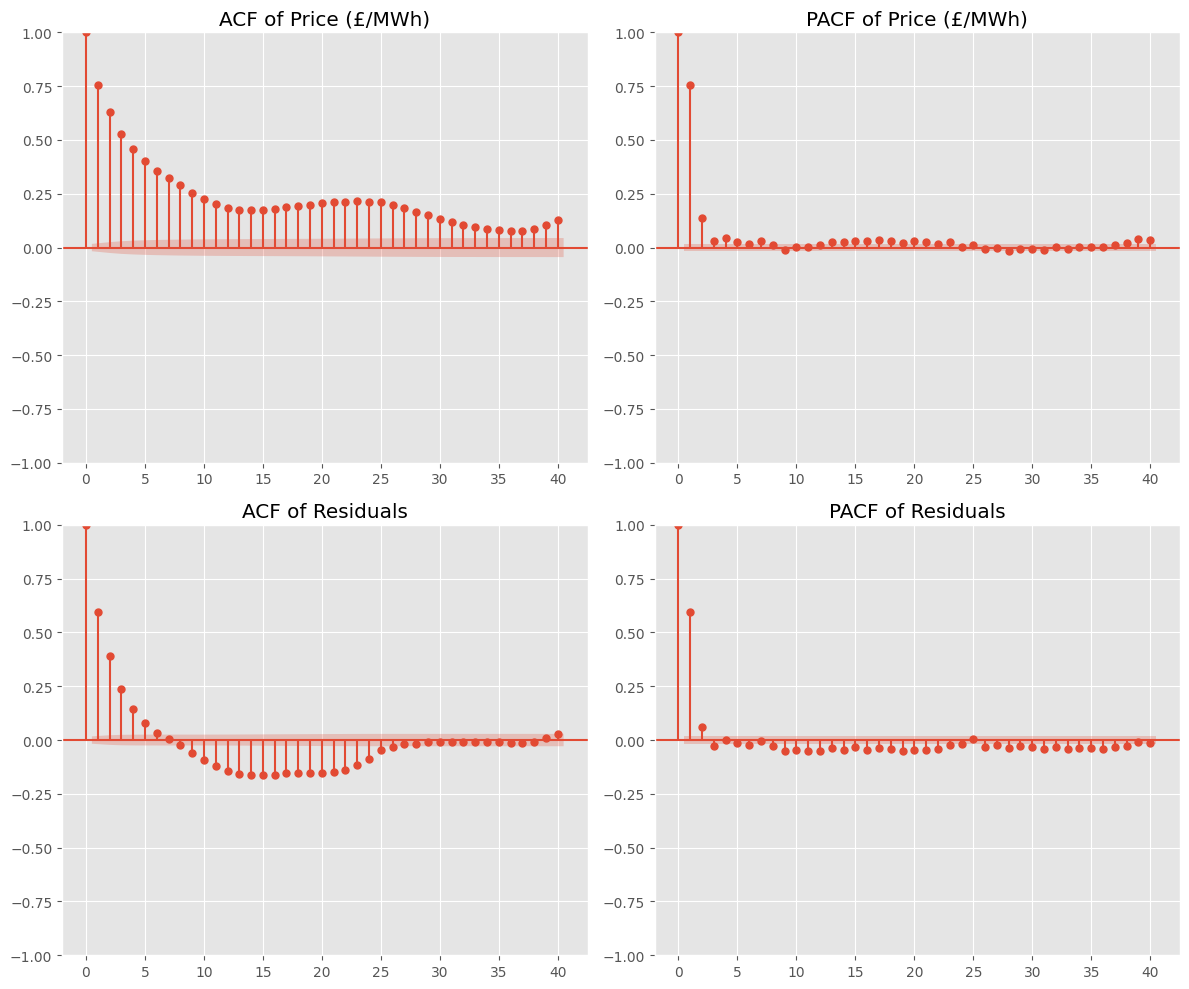

In [13]:
# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot ACF for the 'Price (£/MWh)'
plot_acf(df['Price (£/MWh)'], ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of Price (£/MWh)")

# Plot PACF for the 'Price (£/MWh)'
plot_pacf(df['Price (£/MWh)'], ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of Price (£/MWh)")

# Plot ACF for the residuals
plot_acf(decomposition.resid.dropna(), ax=axes[1, 0], lags=40)
axes[1, 0].set_title("ACF of Residuals")

# Plot PACF for the residuals
plot_pacf(decomposition.resid.dropna(), ax=axes[1, 1], lags=40, method='ywm')
axes[1, 1].set_title("PACF of Residuals")

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

Based on ACF and PACf plot, I then check for the most suitable parameters for a Sarima model. I then select the model with the lowest BIC result

In [14]:
# Filter data and select target column
df = merged_df.loc[(merged_df.index >= '2024-01-01')][['Price (£/MWh)']].copy()

# Train-Test Split 80% for training, 20% for testing

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Select the series from training set
series = train.iloc[:, 0]


# SARIMA Grid Search on Train

p_values = range(2)
q_values = range(2)
P_values = range(2)
Q_values = range(2)

# Fixed orders
d = 1
D = 0
s = 48  # 30-minute intervals = 48 steps/day

results_list = []

for p, q, P, Q in itertools.product(p_values, q_values, P_values, Q_values):
    order = (p, d, q)
    seasonal_order = (P, D, Q, s)
    try:
        model = sm.tsa.SARIMAX(series, order=order, seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic
        bic = result.bic
        print(f"Tested SARIMA{order}x{seasonal_order} - AIC: {aic:.2f}, BIC: {bic:.2f}")
        results_list.append({
            'p': p, 'd': d, 'q': q,
            'P': P, 'D': D, 'Q': Q, 's': s,
            'AIC': aic, 'BIC': bic
        })
    except Exception as e:
        print(f"SARIMA{order}x{seasonal_order} failed: {e}")
        results_list.append({
            'p': p, 'd': d, 'q': q,
            'P': P, 'D': D, 'Q': Q, 's': s,
            'AIC': np.nan, 'BIC': np.nan
        })

# Sort and View Top Models

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='BIC')

print("\nTop SARIMA models by BIC:")
print(results_df.head())


Tested SARIMA(0, 1, 0)x(0, 0, 0, 48) - AIC: 98158.80, BIC: 98166.07
Tested SARIMA(0, 1, 0)x(0, 0, 1, 48) - AIC: 98148.43, BIC: 98162.95
Tested SARIMA(0, 1, 0)x(1, 0, 0, 48) - AIC: 98147.85, BIC: 98162.37
Tested SARIMA(0, 1, 0)x(1, 0, 1, 48) - AIC: 97969.60, BIC: 97991.38
Tested SARIMA(0, 1, 1)x(0, 0, 0, 48) - AIC: 97345.45, BIC: 97359.97
Tested SARIMA(0, 1, 1)x(0, 0, 1, 48) - AIC: 97315.14, BIC: 97336.92
Tested SARIMA(0, 1, 1)x(1, 0, 0, 48) - AIC: 97312.88, BIC: 97334.66
Tested SARIMA(0, 1, 1)x(1, 0, 1, 48) - AIC: 97041.08, BIC: 97070.13
Tested SARIMA(1, 1, 0)x(0, 0, 0, 48) - AIC: 97542.70, BIC: 97557.22
Tested SARIMA(1, 1, 0)x(0, 0, 1, 48) - AIC: 97522.51, BIC: 97544.30
Tested SARIMA(1, 1, 0)x(1, 0, 0, 48) - AIC: 97521.34, BIC: 97543.12
Tested SARIMA(1, 1, 0)x(1, 0, 1, 48) - AIC: 97317.29, BIC: 97346.34
Tested SARIMA(1, 1, 1)x(0, 0, 0, 48) - AIC: 96586.86, BIC: 96608.65
Tested SARIMA(1, 1, 1)x(0, 0, 1, 48) - AIC: 96562.50, BIC: 96591.55
Tested SARIMA(1, 1, 1)x(1, 0, 0, 48) - AIC: 9656

Testing the model with the lowest BIC value and plotting the predictions vs actual values

In [15]:
# Select Best Model from Grid Search
best_params = results_df.iloc[0]  # Row with the lowest BIC

# Extract parameters
order = (int(best_params['p']), int(best_params['d']), int(best_params['q']))
seasonal_order = (int(best_params['P']), int(best_params['D']), int(best_params['Q']), int(best_params['s']))

print(f"\nRefitting best SARIMA{order}x{seasonal_order} on training data...")

# Refit Model on Train Data
model = sm.tsa.SARIMAX(train.iloc[:, 0], order=order, seasonal_order=seasonal_order)
fitted_model = model.fit(disp=False)


# Forecast for Test Period
n_test = len(test)
forecast = fitted_model.forecast(steps=n_test)

# Evaluate Forecast Accuracy

actual = test.iloc[:, 0]
rmse = np.sqrt(mean_squared_error(actual, forecast))
mae = mean_absolute_error(actual, forecast)

print(f"\nForecast evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Create the figure
fig = go.Figure()

# Add the train data (last 2 days)
fig.add_trace(go.Scatter(
    x=train.index[-96:], 
    y=train.iloc[-96:, 0], 
    mode='lines', 
    name='Train (last 2 days)', 
    line=dict(color='gray')
))

# Add the actual test data
fig.add_trace(go.Scatter(
    x=test.index, 
    y=actual, 
    mode='lines', 
    name='Actual', 
    line=dict(color='blue')
))

# Add the forecast data
fig.add_trace(go.Scatter(
    x=test.index, 
    y=forecast, 
    mode='lines', 
    name='Forecast', 
    line=dict(color='orange')
))

# Update layout
fig.update_layout(
    title='SARIMA Forecast vs Actuals',
    xaxis_title='Timestamp',
    yaxis_title='Price (£/MWh)',
    legend_title='Legend',
    template='plotly_white',
    height=600,
    width=1000
)

# Show the plot
fig.show()



Refitting best SARIMA(1, 1, 1)x(1, 0, 1, 48) on training data...

Forecast evaluation:
RMSE: 56.90
MAE: 50.65


Model summary and residual analysis

                                     SARIMAX Results                                      
Dep. Variable:                      Price (£/MWh)   No. Observations:                10521
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 48)   Log Likelihood              -48101.736
Date:                            Mon, 21 Apr 2025   AIC                          96213.472
Time:                                    19:25:21   BIC                          96249.778
Sample:                                01-01-2024   HQIC                         96225.731
                                     - 08-07-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6266      0.008     79.794      0.000       0.611       0.642
ma.L1         -0.9602      0.003   

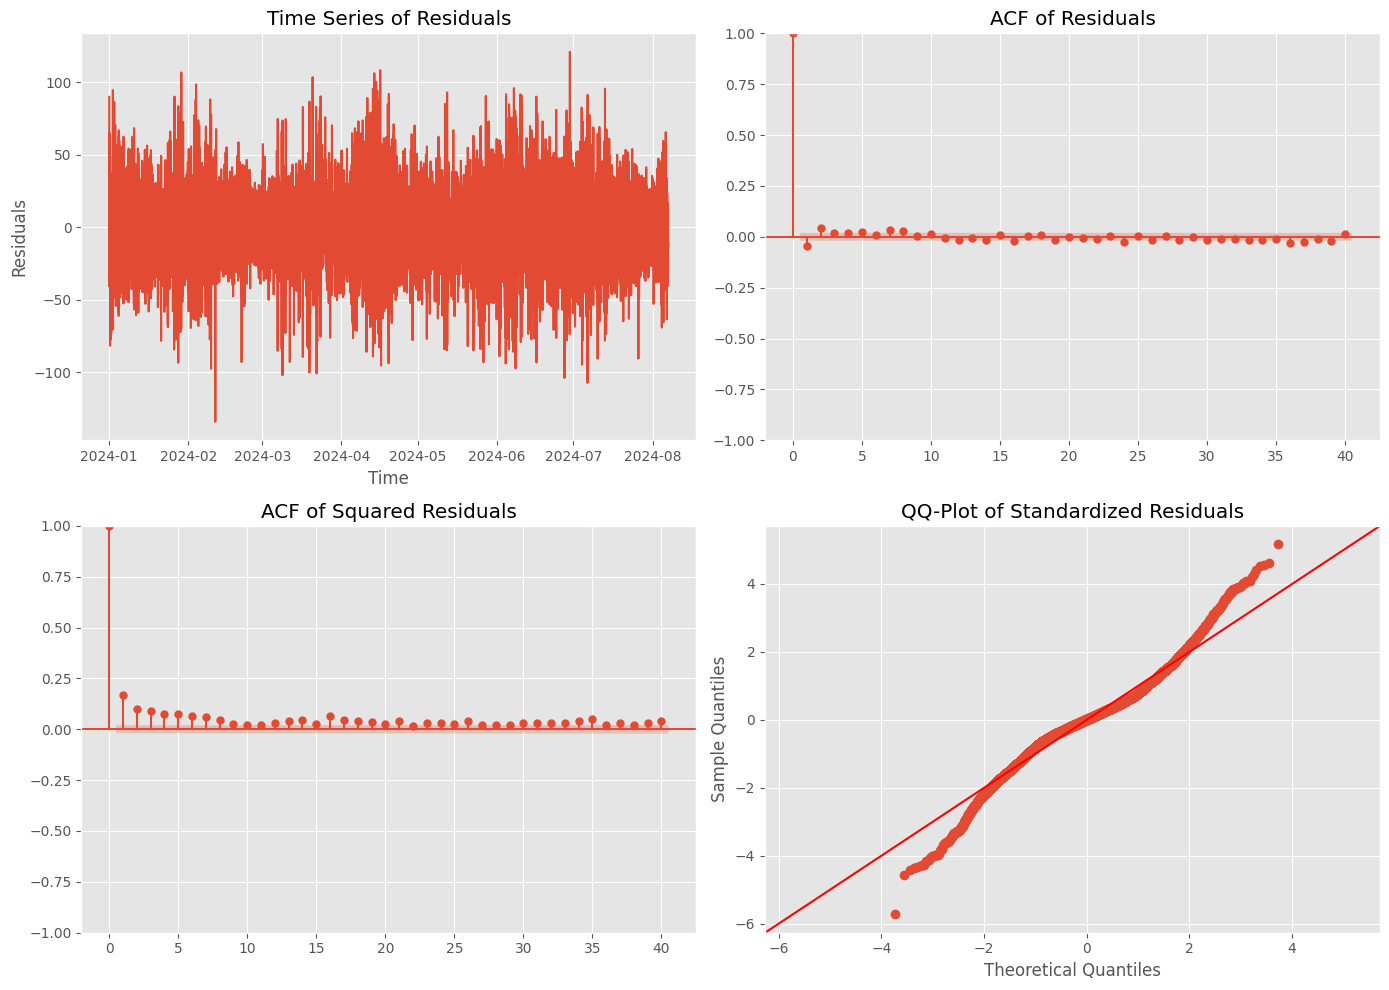

In [16]:
# Print the model summary
print(fitted_model.summary())

# 'best_result' is the BIC based model from which we extract residuals.
resid = fitted_model.resid
resid_sq = resid ** 2

# Standardize the residuals for the QQ-plot.
resid_std = (resid - resid.mean()) / resid.std()

# Create a 2x2 grid of diagnostic plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top-Left: Time Series of Residuals
axs[0, 0].plot(resid, linestyle='-')
axs[0, 0].set_title("Time Series of Residuals")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Residuals")

# Top-Right: ACF of Residuals
sm.graphics.tsa.plot_acf(resid, lags=40, ax=axs[0, 1])
axs[0, 1].set_title("ACF of Residuals")

# Bottom-Left: ACF of Squared Residuals
sm.graphics.tsa.plot_acf(resid_sq, lags=40, ax=axs[1, 0])
axs[1, 0].set_title("ACF of Squared Residuals")

# Bottom-Right: QQ-Plot of Standardized Residuals
sm.qqplot(resid_std, line='45', ax=axs[1, 1])
axs[1, 1].set_title("QQ-Plot of Standardized Residuals")

plt.tight_layout()
plt.show()


Refit model with the data from 2024

In [17]:
# Refit best SARIMA model on the full dataset
model = sm.tsa.SARIMAX(df.iloc[:, 0], order=order, seasonal_order=seasonal_order)
fitted_model = model.fit(disp=False)

# Print summary of the final model
print("Final SARIMA Model (trained on full dataset):")
print(fitted_model.summary())


Final SARIMA Model (trained on full dataset):
                                     SARIMAX Results                                      
Dep. Variable:                      Price (£/MWh)   No. Observations:                13152
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 48)   Log Likelihood              -60514.296
Date:                            Mon, 21 Apr 2025   AIC                         121038.593
Time:                                    19:27:21   BIC                         121076.014
Sample:                                01-01-2024   HQIC                        121051.089
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6348      0.007     88.398      0.000       0.621  

Making future prediction for 1st October 2024

In [18]:
# Forecast 1 day ahead = 1 * 48 (since it's 30-minute intervals)
steps_ahead = 1 * 48

future_forecast = fitted_model.get_forecast(steps=steps_ahead)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()


# Combine into a single DataFrame
forecast_df = pd.DataFrame({
    'Forecast (£/MWh)': future_mean,
    'Lower Bound': future_ci.iloc[:, 0],
    'Upper Bound': future_ci.iloc[:, 1]
})

# Preview the forecast
print(forecast_df.head())



                     Forecast (£/MWh)  Lower Bound  Upper Bound
2024-10-01 00:00:00         52.117335     4.925517    99.309152
2024-10-01 00:30:00         50.898849    -6.011095   107.808794
2024-10-01 01:00:00         55.680175    -5.348573   116.708923
2024-10-01 01:30:00         51.296263   -11.754615   114.347140
2024-10-01 02:00:00         53.518351   -10.646427   117.683128


In [19]:
forecast_df.to_csv('Sarima_price_prediction.csv', index=True)

When compared to actual data, the RMSE for this was found to be 34.7469

In [20]:
# Create a Plotly figure
fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(
    x=df.index[-300:], y=df.iloc[-300:, 0], mode='lines', name='Historical Data',line=dict(color='blue')
))

# Add forecast data
fig.add_trace(go.Scatter(
    x=future_mean.index, y=future_mean, mode='lines', name='Forecast', line=dict(color='red')
))

# Add confidence interval as a filled area
fig.add_trace(go.Scatter(
    x=future_ci.index.tolist() + future_ci.index[::-1].tolist(), y=future_ci.iloc[:, 0].tolist() + future_ci.iloc[:, 1][::-1].tolist(),
    fill='toself', fillcolor='rgba(255, 182, 193, 0.3)', line=dict(color='rgba(255, 182, 193, 0)'),
    hoverinfo="skip",
    name='Confidence Interval'
))

# Update layout
fig.update_layout(
    title="1-Day Forecast (£/MWh)", xaxis_title="Time", yaxis_title="Price (£/MWh)",
    legend_title="Legend",
    template="plotly_white",
    height=600,
    width=1000
)

# Show the plot
fig.show()

# 6. XG Boost Model

Using XG Boost and data from 2024 only, I check which variables to use as features for my prediction model

In [21]:
column_list = list(merged_df.columns)

df = merged_df.copy()

price = [col for col in column_list if col == 'Price (£/MWh)']
features_to_check = [col for col in column_list if col != 'Price (£/MWh)']

y = df[price]
X = df[features_to_check]

train = df.loc[(df.index >= '2024-01-01') & (df.index <= '2024-09-01')]

test = df.loc[df.index >= '2024-09-01']

X_train = train[features_to_check] 
y_train = train[price] 
X_test = test[features_to_check] 
y_test = test[price]

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
xgb_regressor = xgb.XGBRegressor(objective='reg:linear', early_stopping_rounds=10)
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"\nBest Score: {grid_search.best_score_}\n")
best_model = grid_search.best_estimator_
best_model

# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to display feature importances with feature names
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
importance_df


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   3.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

Feature  Importance
0                           net_imbalnace_volume (MW)    0.593470
21  Intraday Price (EPEX Outturn, APX, MID) - GB (...    0.233214
17  Actual Aggregated Generation By Type - Solar -...    0.017967
11  Actual Aggregated Generation By Type - Fossil ...    0.016884
20  Day Ahead Price (EPEX half-hourly, local) - GB...    0.013467
16  Actual Aggregated Generation By Type - Nuclear...    0.012200
4             Total BSAD Volume - Turn Down - GB (MW)    0.010084
6   Intraday Volume (EPEX Outturn, APX, MID) - GB ...    0.010012
5                 Total BSAD Volume - Total - GB (MW)    0.009305
15  Actual Aggregated Generation By Type - Hydro R...    0.009152
1                             BM Bid Acceptances (MW)    0.008877
18  Actual Aggregated Generation By Type - Wind On...    0.008831
2              BM Offer Acceptances (total) - GB (MW)    0.008590
3               Total BSAD Volume - Turn Up - GB (MW)    0.008346
10  Actual Aggregated Generation By Type - Biomass...    0.007845
9                    Demand Outturn (ITSDO) - GB (MW)    0.007843
14  Actual Aggregated Generation By Type - Hydro P...    0.006746
8                         Actual Total Load - GB (MW)    0.006070
19  Actual Aggregated Generation By Type - Wind Of...    0.005720
12  Actual Aggregated Generation By Type - Fossil ...    0.005378
13  Actual Aggregated Generation By Type - Fossil ...    0.000000
7           Loss of Load Probability - Latest - GB ()    0.000000

Now I will focus on on using net imbalance volume to predict price

RMSE: 24.249375755853013
MAE: 19.492256348353294
R2: 0.5948473533374437


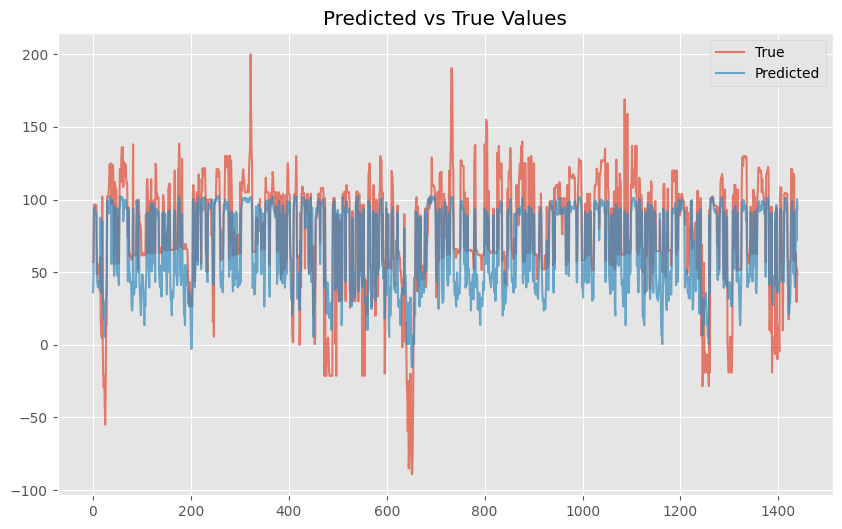

In [22]:
df = merged_df.loc[(merged_df.index >= '2024-01-01')][['Price (£/MWh)', 'net_imbalnace_volume (MW)']].copy()

# Define the feature and target
train = df.loc[df.index < '2024-09-01']
test = df.loc[df.index >= '2024-09-01']

feature_col = 'net_imbalnace_volume (MW)'
target_col = 'Price (£/MWh)'

# Split into features and target
X_train = train[[feature_col]]
y_train = train[target_col]

X_test = test[[feature_col]]
y_test = test[target_col]


# Initialize the XGBoost regressor with the best parameters
xgb_model = xgb.XGBRegressor(
    learning_rate=0.01,
    max_depth=5,
    n_estimators=500,
    objective='reg:linear'
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("RMSE:", mean_squared_error(y_test, y_pred) ** 0.5)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title("Predicted vs True Values")
plt.legend()
plt.show()

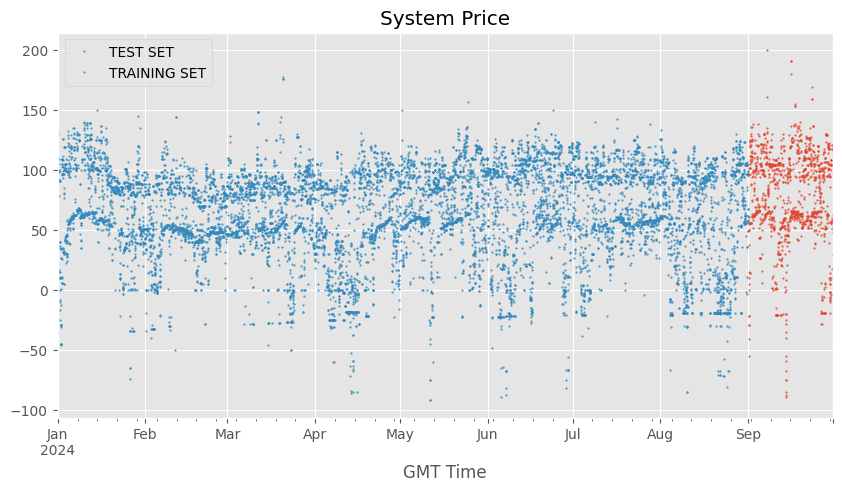

In [23]:
df = pd.DataFrame(merged_df[['Price (£/MWh)']])
df.index = merged_df.index
df.columns = ['Price (£/MWh)']

# Dropping null values 
df.dropna(inplace=True)

# Setting the Training and test split
train = df.loc[(df.index >= '2024-01-01') & (df.index <= '2024-09-01')]
test = df.loc[df.index >= '2024-09-01']

test \
    .rename(columns={'Price (£/MWh)': 'TEST SET'}) \
    .join(train.rename(columns={'Price (£/MWh)': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='System Price', style='.', ms=1)
plt.show()



Using lagged values of Price to predict future Price Values

In [24]:
# Setting the Training and test split
train = df.loc[(df.index >= '2024-01-01') & (df.index <= '2024-09-01')]
test = df.loc[df.index >= '2024-09-01']

# Create fold check points

tss = TimeSeriesSplit(n_splits=5, test_size=48*3*1, gap=48)
df = df.sort_index()

# Add time lags to price data as additional regressors

def add_lags(df):
    target_map = df['Price (£/MWh)'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    return df

df = add_lags(df)

# Create folds to check model RMSE score at various points of the test data

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['lag1','lag2','lag3']
    TARGET = 'Price (£/MWh)'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

# Train the model

    reg = xgb.XGBRegressor(n_estimators=500,
                           objective='reg:linear',
                           max_depth=5,
                           learning_rate=0.01)
# Test the model 

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

#Get performance scores in each fold

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


In [25]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 35.2936
Fold scores:[np.float64(31.108097511207646), np.float64(30.381296782291262), np.float64(32.189743259316444), np.float64(40.47833482611701), np.float64(42.31035897598083)]


In [26]:
# Train with all df to get October 1st prediction

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(n_estimators=500,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=0)

# Create dataframe for October 1st with target value, features and lags used in the prediction model

future = pd.date_range('2024-10-01','2024-10-02', freq='30min')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = add_lags(df_and_future)

# Predict the future

future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'].head()

2024-10-01 00:00:00    57.705338
2024-10-01 00:30:00    39.666965
2024-10-01 01:00:00    60.518379
2024-10-01 01:30:00    41.020603
2024-10-01 02:00:00    64.756134
Name: pred, dtype: float32

In [27]:
#save to CSV

future_w_features.rename(columns={'pred': 'System Price (ESO Outturn) - GB (£/MWh)'}, inplace=True)

result = future_w_features['System Price (ESO Outturn) - GB (£/MWh)'].head(48)
# Rename the index to 'GMT Time' 
result.index.name = 'GMT Time'

# Save the result to a CSV file
result.to_csv('XGBoost_Price_predictions.csv', index=True)
